In [3]:
import networkx as nx
import random
import numpy as np
import pandas as pd

import network_build
import imp

imp.reload(network_build)

import seaborn as sns
import matplotlib.pyplot as plt


def single_sink_longest_dag_path(graph, s):
    assert graph.out_degree(s) == 0
    dist = dict.fromkeys(graph.nodes, -float("inf"))
    dist[s] = 0
    topo_order = list(reversed(list(nx.topological_sort(graph))))
    for n in topo_order:
        for s in graph.predecessors(n):
            if dist[s] < dist[n] + 1:
                dist[s] = dist[n] + 1
    return dist

C:\Users\Admin\AppData\Local\Temp\ipykernel_3420\2861574340.py:7: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [9]:
# load data
driver = pd.read_csv("..//..//..//Database//NYC_trip//driver_260.csv", index_col=0)
order = pd.read_csv("..//..//..//Database//NYC_trip//order_clean_260.csv", index_col=0)
area = np.load("..//..//..//Database//NYC_area//NY_area.npy")

In [11]:
# xtick label format setting
hours = list(range(24 + 1))
hourlabels = [f"{h:02d}:{00:02d}" for h in hours]  # ["00:00", "01:00", ... "23:00", "24:00"]
minutes = list(range(240))
minutelabels = [f"{8 + m//60:02d}:{(m) %60:02d}" for m in range(240)]

# create driver's pick up time
order["call_time"] = pd.to_datetime(order["call_time"])
order["end_time"] = pd.to_datetime(order["end_time"])
start_time = pd.to_datetime("2022-06-02 08:00:00 AM")
driver["time"] = pd.date_range(start=start_time, end=start_time, periods=len(driver))
driver.columns = ["id", "time"]
driver_pick = driver.values

# select all orders in the first 2 hours 
start_time = pd.to_datetime("2022-06-01 08:00:00 AM")
end_time = pd.to_datetime("2022-06-01 12:00:00 PM")
order_pick = order[(order["call_time"] >= start_time) & (order["call_time"] < end_time)]
order_pick = order_pick[["sid", "call_time", "eid", "end_time"]].sort_values(by="call_time")
order_pick = order_pick.reset_index(drop=True)
total_order_num = len(order_pick)

# Construct network iteratively

In [21]:
SP_interval = 60
SP = dict()

start_time_current = order_pick["call_time"][0]
end_time_current = start_time + pd.Timedelta(minutes=SP_interval)
order_pick_current = order_pick[
    (order_pick["call_time"] >= start_time_current) & (order_pick["call_time"] < end_time_current)
]

pointer_a = 0
pointer_b = order_pick_current.index[-1]

net = network_build.ConstructNetwork(order_pick_current.values, driver_pick, area, void = 10)
G_order = net.build_network(network_type="order")
G_order.add_node('sink')
for node in G_order.nodes():
    if node != 'sink':
        G_order.add_edge(node, 'sink', weight=0)

MTC = single_sink_longest_dag_path(G_order, 'sink')
SP['t' + str(pointer_a)] = MTC['t' + str(pointer_a)]

In [25]:
for i in range(len(order_pick)) :
    start_time_current = order_pick["call_time"][i]
    end_time_current = start_time_current + pd.Timedelta(minutes=SP_interval)
    order_pick_current = order_pick[(order_pick["call_time"] <= end_time_current)]
    order_pick_current = order_pick_current.iloc[i:, :]
    if order_pick_current is None:
        print('No order in the current time interval')
        continue
    if order_pick_current.index[0] > pointer_a:
        remove_nodes_list = [i for i in range(pointer_a, order_pick_current.index[0])]
        net.prune_network(G_order, remove_nodes_list)
        pointer_a = order_pick_current.index[0]

    if order_pick_current.index[-1] > pointer_b:
        expand_nodes = order_pick_current.loc[order_pick_current.index > pointer_b]
        expand_nodes_list = [i for i in expand_nodes.index]
        G_order = net.expand_network(G_order, expand_nodes.values, expand_nodes_list)
        pointer_b = order_pick_current.index[-1]
    
    MTC = single_sink_longest_dag_path(G_order, 'sink')
    SP['t' + str(pointer_a)] = MTC['t' + str(pointer_a)]

{5620: []}


# Construct network and save

In [7]:
# create 4-hour network
# start_time = pd.to_datetime("2022-06-02 06:00:00 AM") 
# end_time = pd.to_datetime("2022-06-02 11:00:00 AM")
# order_pick = order[(order["call_time"] > start_time) & (order["call_time"] <= end_time)]
# order_pick = order_pick[["sid", "call_time", "eid", "end_time"]]
# order_pick = order_pick.values

# net = network_build.ConstructNetwork(order_pick, driver_pick, area, void = 10)
# G_order = net.build_network(network_type="order")
# net.saveNetwork(G_order, "..//..//..//Database//network_test_0305//order.gpickle")
# df_4h = net.network_metrics(G_order)

In [13]:
# net = network_build.ConstructNetwork(order_pick, driver_pick, area, void = 10)
# G_order = nx.read_gpickle("..//..//..//Database//network_test_0305//order.gpickle")
# df_4h = net.network_metrics(G_order)
SP_data = pd.read_csv("..//..//..//Database//network_test_0305//SP.csv", index_col=0)

<AxesSubplot: xlabel='0'>

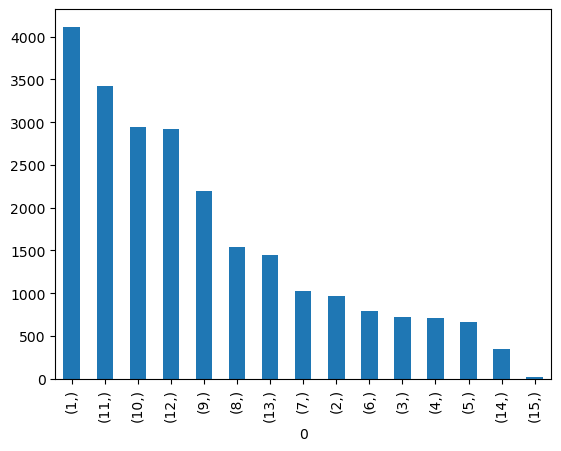

In [15]:
SP_data.value_counts().plot(kind='bar')

In [12]:
df_4h['SP_60'] = list(SP.values())
df_4h.to_csv("..//..//..//Database//network8_10_june2//network_metrics_SP_60.csv")

In [1]:
# figure, axes = plt.subplots(6, 1, figsize=(20, 16), tight_layout=True)
# axes = axes.flatten()
# sns.violinplot(x="time", y="degree", data=df_all, ax=axes[0], fill=False)
# sns.violinplot(x="time", y="in_degree", data=df_all, ax=axes[1], fill=False)
# sns.violinplot(x="time", y="out_degree", data=df_all, ax=axes[2], fill=False)

# sns.violinplot(x="time", y="closeness_centrality", data=df_all, ax=axes[3])
# sns.violinplot(x="time", y="betweenness_centrality", data=df_all, ax=axes[4])
# sns.violinplot(x="time", y="katz_centrality", data=df_all, ax=axes[5])
# plt.show()

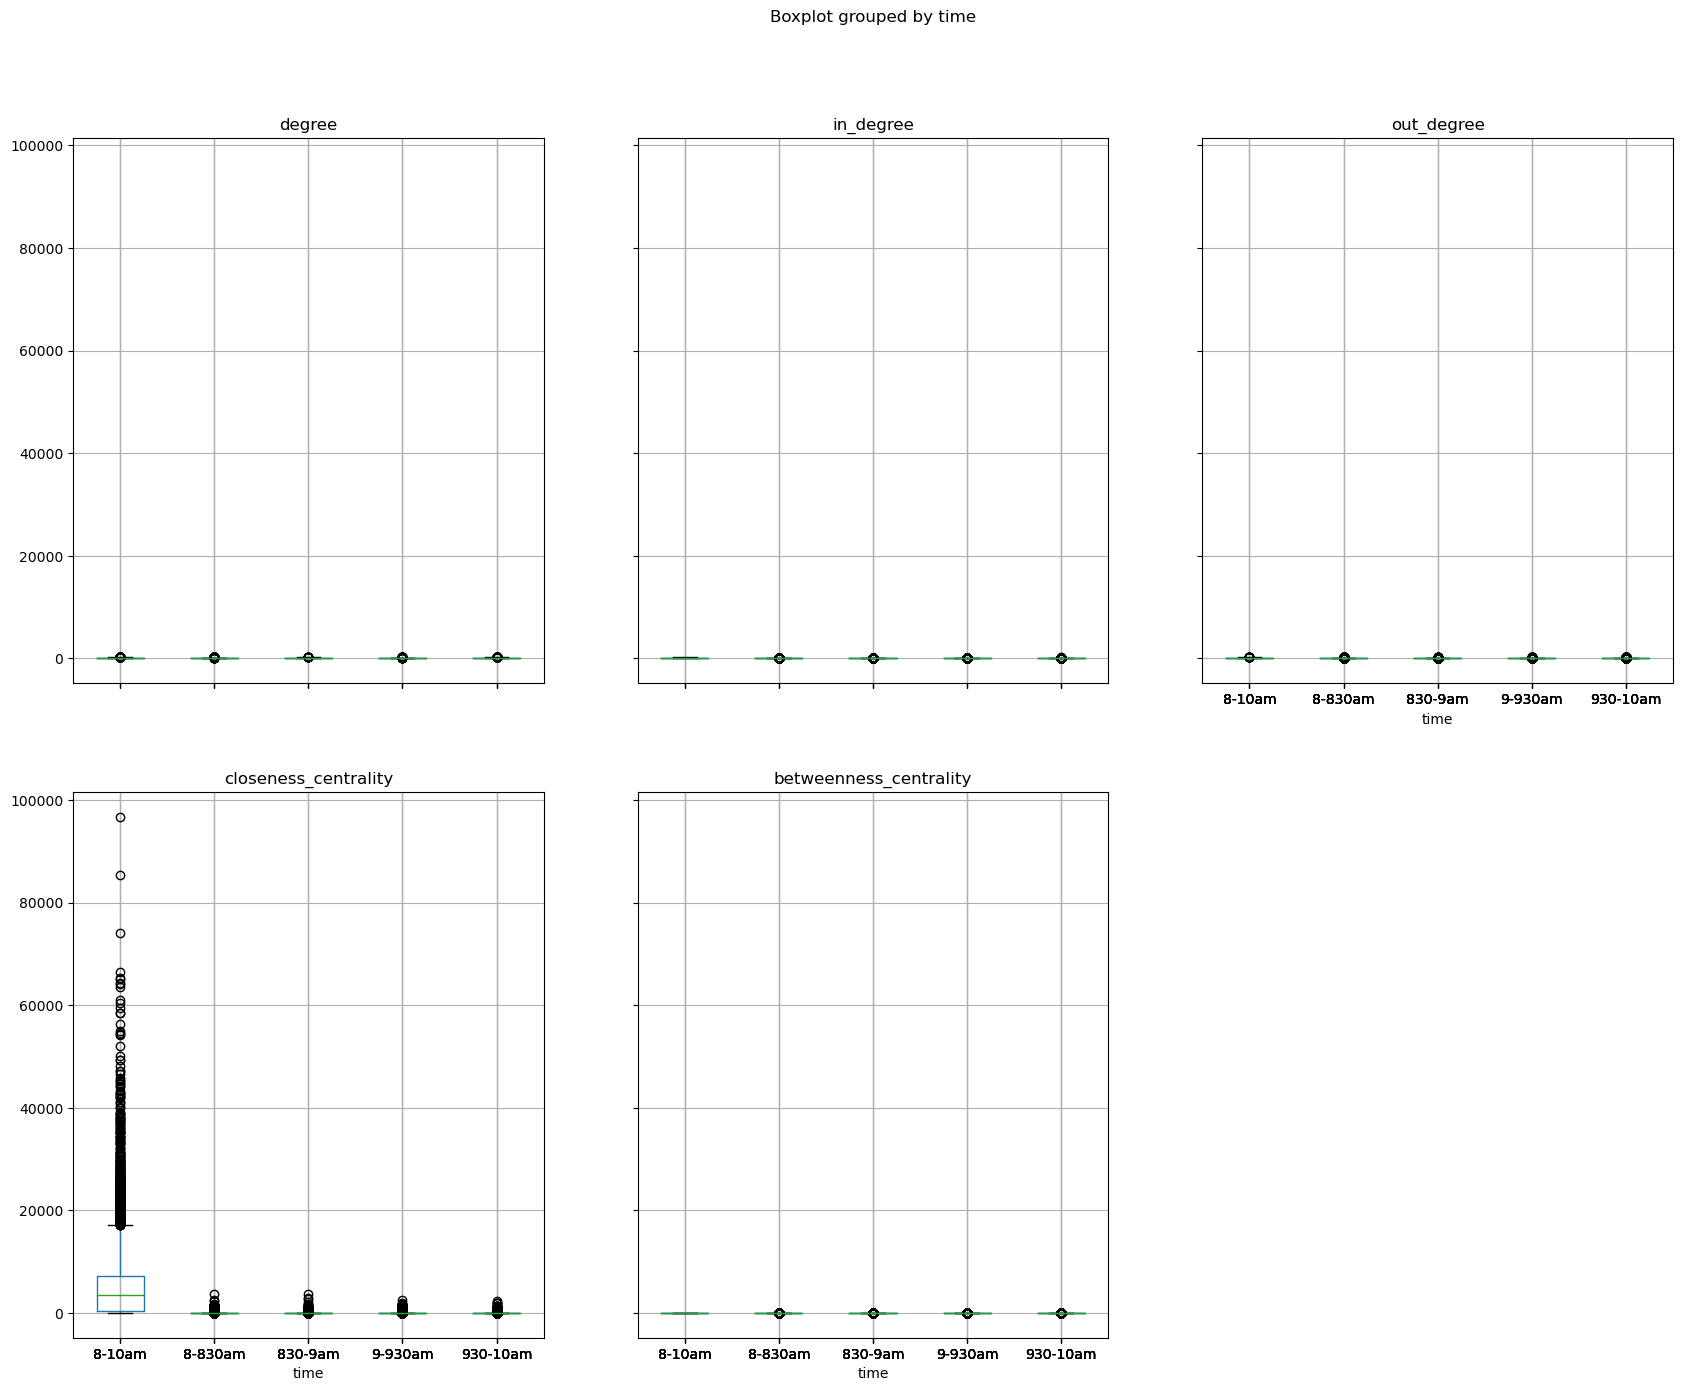

In [14]:
# df_all.boxplot(column=["degree", "in_degree", "out_degree", "closeness_centrality", "betweenness_centrality"], by="time", figsize=(20, 16), layout=(2, 3))
# plt.show()

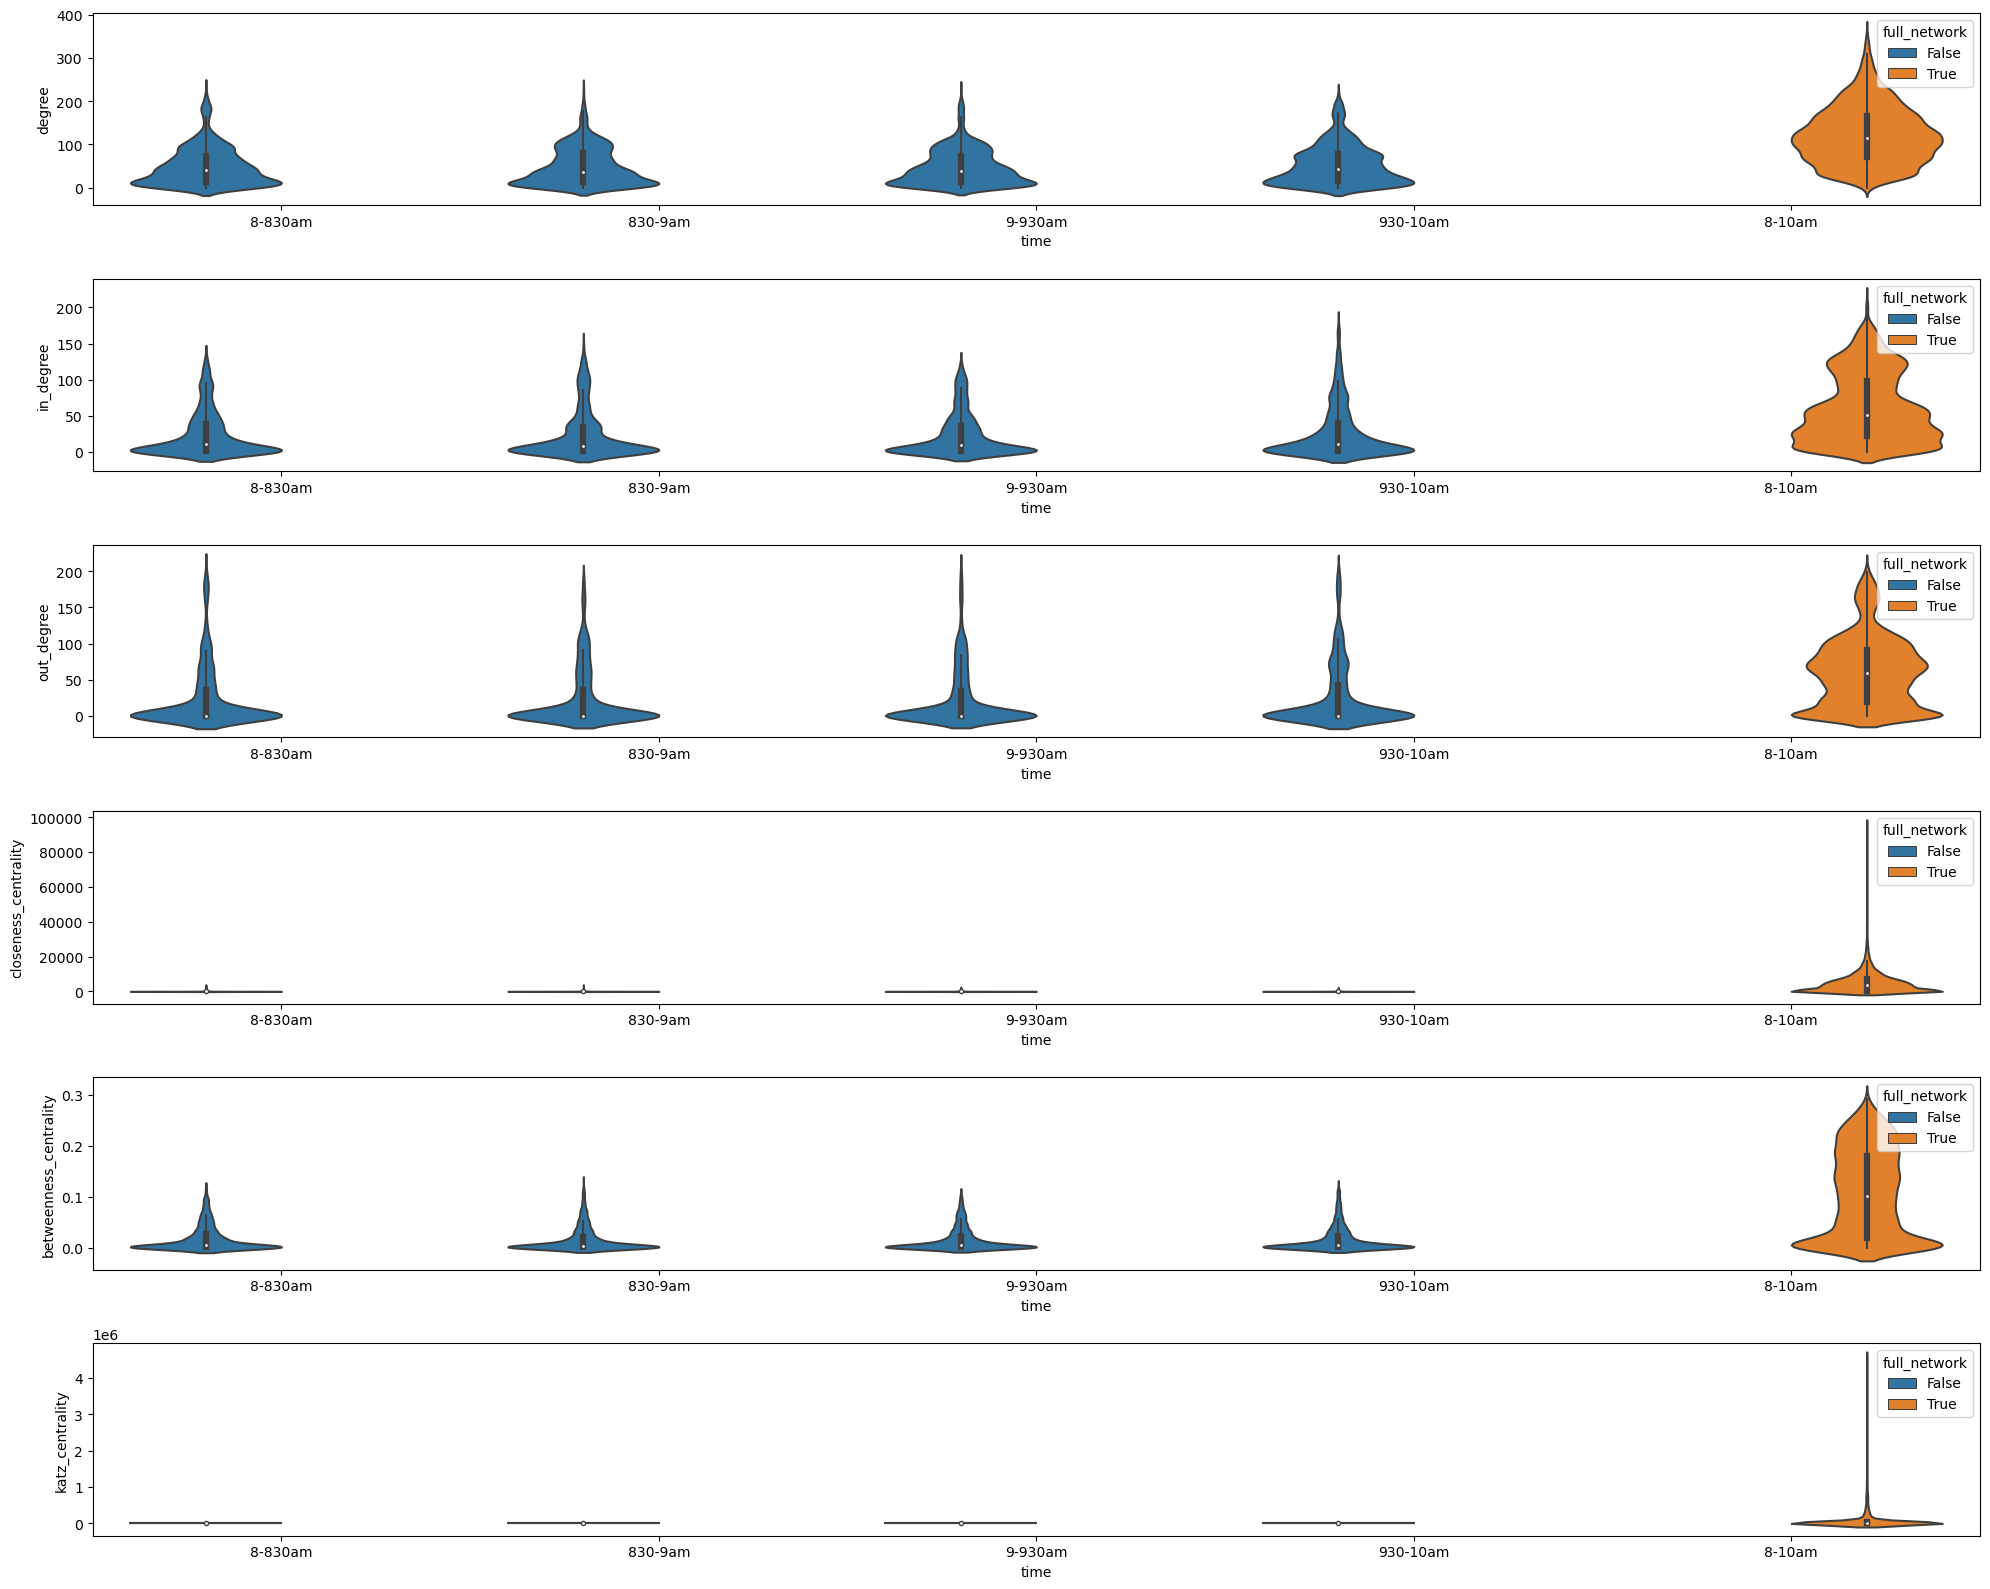

In [15]:
# figure, axes = plt.subplots(6, 1, figsize=(20, 16), tight_layout=True)
# axes = axes.flatten()
# sns.violinplot(x="time", y="degree", data=df_all, hue='full_network', ax=axes[0])
# sns.violinplot(x="time", y="in_degree", data=df_all, hue='full_network', ax=axes[1])
# sns.violinplot(x="time", y="out_degree", data=df_all, hue='full_network', ax=axes[2])

# sns.violinplot(x="time", y="closeness_centrality", data=df_all, hue='full_network',  ax=axes[3])
# sns.violinplot(x="time", y="betweenness_centrality", data=df_all, hue='full_network', ax=axes[4])
# sns.violinplot(x="time", y="katz_centrality", data=df_all, hue='full_network', ax=axes[5])
# plt.show()

NameError: name 'df_all_new' is not defined

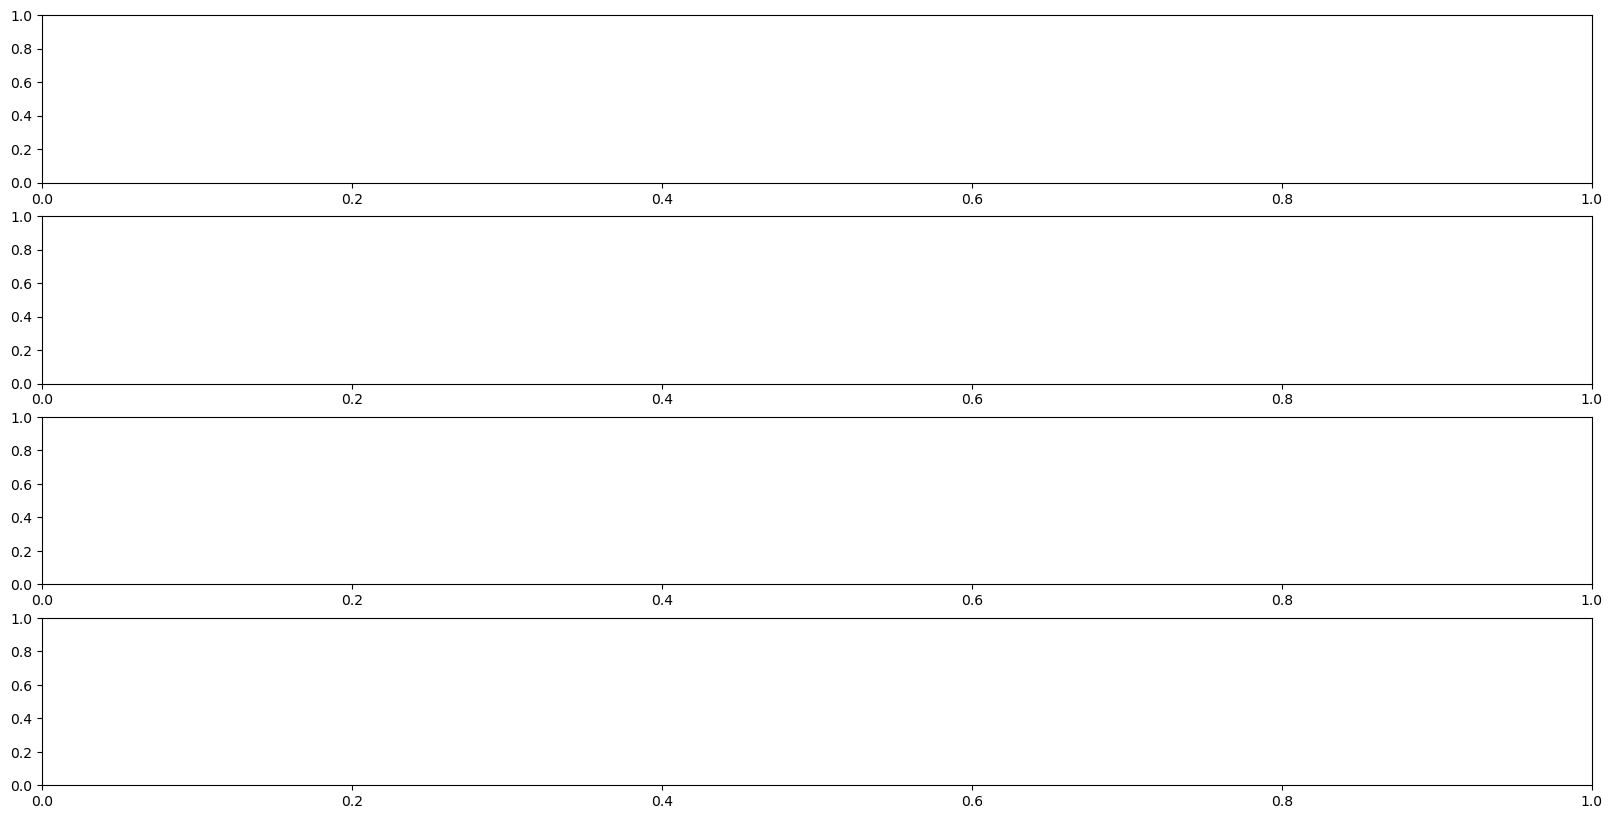

In [17]:
# figure, axes = plt.subplots(4, 1, figsize=(20, 10))
# axes = axes.flatten()
# sns.boxplot(x="time", y="degree_centrality", data=df_all_new, hue='full_network', ax=axes[0])
# sns.boxplot(x="time", y="closeness_centrality", data=df_all_new, hue='full_network',  ax=axes[1])
# sns.boxplot(x="time", y="betweenness_centrality", data=df_all_new, hue='full_network', ax=axes[2])
# sns.boxplot(x="time", y="katz_centrality", data=df_all_new, hue='full_network', ax=axes[3])
# plt.show()